# Electricity Price Forecasting with ARIMA
Electricity is a *basic human need* and definitely one of the most important factors of societal progress. In recent decades however, electricity has entered the market as a tradeable commodity and the power industry of many countries has been **deregulated**. In Spain, the Electric Power Act 54/1997 exposed all of the stakeholders to **high amounts of uncertainty** as the price of electricity is determined by countless factors and also, due to the fact that electricity cannot be stored in large quantities efficiently [[1]](#ref1). With the emergence of this new market, the need for reliable forecasting methods at all scales (hourly, daily, long-term, etc.) has also emerged and has become a large area of research.

A popular and widely used statistical method for time series forecasting is the ARIMA model. It is one of the most popular models to predict linear time series data. This model has been used extensively in the field of finance and economics as it is known to be robust, efficient, and has a strong potential for short-term share market prediction. Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the auto-correlation(Autocorrelation is the degree of similarity between a given time series and a lagged version of itself over successive time intervals) in the data.


In [1]:
pip install pmdarima

  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
Note: you may need to restart the kernel to use updated packages.


ERROR: tensorflow 2.3.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# from nsepy import get_history
from datetime import date


%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# pip install --upgrade scikit-learn==0.21.2

In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Exploration and Cleaning</a>
This dataset contains information about the electricity generation in Spain for the period 2015-2019 (4 years). In particular:


> **`'energy_dataset.csv':`** Contains hourly information about the generation of energy in Spain. In particular, there is info (in MW) about the amount of electricty generated by the various energy sources (fossil gas, fossil hard coal and wind energy dominate the energy grid), as well as about the total load (energy demand) of the national grid and the price of energy (&euro;/MWh). 
_Note: Since the generation of each energy type is in MW and the time-series contains hourly info, the value of each cell represents MWh (Megawatt hours)._


In [5]:
# Read the datasets
df_energy = pd.read_csv('D:/Data Science_Personal Project/Spain Elect Price Forecasting/energy_dataset.csv', 
    parse_dates=['time']
)

In [6]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable. We will also remove the columns which will not be used at all in our analysis and which contain day-ahead forecasts for the total load, the solar energy and the wind energy.

In [7]:
df_energy.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.0,35046.00,35046.00,35045.00,35046.0,35046.0,35046.0,0.0,...,35045.00,35046.0,35046.00,35064.00,0.0,35064.00,35064.00,35028.00,35064.00,35064.00
mean,383.51,448.06,0.0,5622.74,4256.07,298.32,0.0,0.0,0.0,NaN,...,269.45,0.0,5464.48,1439.07,NaN,5471.22,28712.13,28696.94,49.87,57.88
std,85.35,354.57,0.0,2201.83,1961.60,52.52,0.0,0.0,0.0,NaN,...,50.20,0.0,3213.69,1677.70,NaN,3176.31,4594.10,4574.99,14.62,14.20
min,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,NaN,...,0.00,0.0,0.00,0.00,NaN,237.00,18105.00,18041.00,2.06,9.33
25%,333.00,0.00,0.0,4126.00,2527.00,263.00,0.0,0.0,0.0,NaN,...,240.00,0.0,2933.00,69.00,NaN,2979.00,24793.75,24807.75,41.49,49.35
50%,367.00,509.00,0.0,4969.00,4474.00,300.00,0.0,0.0,0.0,NaN,...,279.00,0.0,4849.00,576.00,NaN,4855.00,28906.00,28901.00,50.52,58.02
75%,433.00,757.00,0.0,6429.00,5838.75,330.00,0.0,0.0,0.0,NaN,...,310.00,0.0,7398.00,2636.00,NaN,7353.00,32263.25,32192.00,60.53,68.01
max,592.00,999.00,0.0,20034.00,8359.00,449.00,0.0,0.0,0.0,NaN,...,357.00,0.0,17436.00,5836.00,NaN,17430.00,41390.00,41015.00,101.99,116.80


In [8]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

The 'time' column, which we also want to function as the index of the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [9]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [10]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 70529 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


As we can see, `df_energy` has no duplicate values. Nevertheless, it has some NaNs and thus, we have to investigate further. Since this is a time-series forecasting task, we cannot simply drop the rows with the missing values and it would be a better idea to fill the missing values using interpolation.

In [11]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                                  18
generation waste                              

In [12]:
df_energy_new = df_energy.filter(['time','price actual'], axis=1)

In [13]:
df_energy_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price actual  35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


**The good news is that there are no NaNs in the 'price actual' column, which we will use as the target variable in order to train our model.**

### Let us create a visualization which will show per day price of the electricity

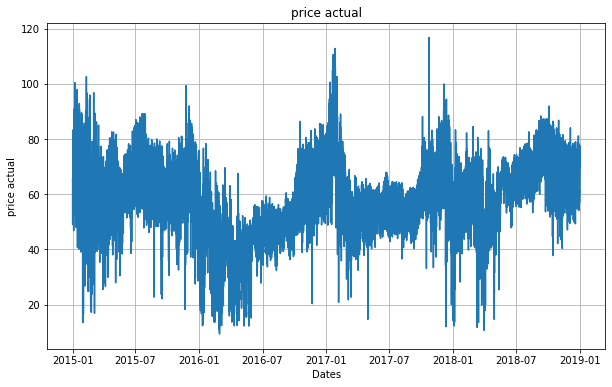

In [14]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('price actual')
plt.plot(df_energy_new['price actual'])
plt.title('price actual')
plt.show()

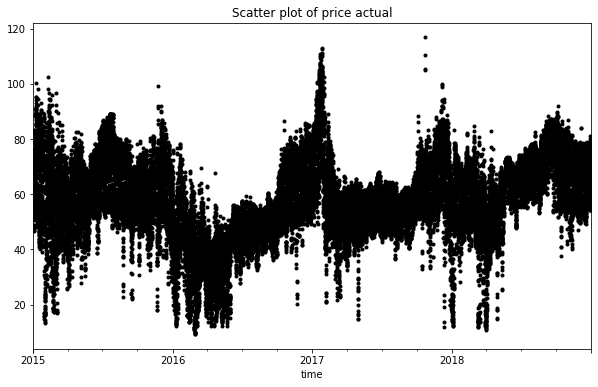

In [15]:
plt.figure(figsize=(10,6))
df_price = df_energy_new['price actual']
df_price.plot(style='k.')
plt.title('Scatter plot of price actual')
plt.show()

First, we need to check if a series is stationary or not because time series analysis only works with stationary data. If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., “stationarised”) through the use of mathematical transformations. A stationarised series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past! Another reason for trying to stationarise a time series is to be able to obtain meaningful sample statistics such as means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary. For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables.

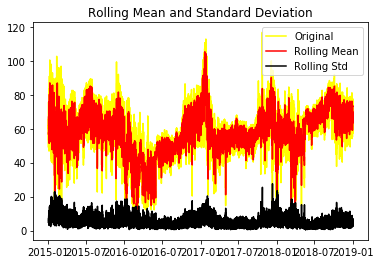

Results of dickey fuller test
Test Statistics               -9.147016e+00
p-value                        2.750493e-15
No. of lags used               5.000000e+01
Number of observations used    3.501300e+04
critical value (1%)           -3.430537e+00
critical value (5%)           -2.861623e+00
critical value (10%)          -2.566814e+00
dtype: float64


In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity((df_energy_new['price actual']))

To identify the nature of the data, we will be using the null hypothesis.

#Ho: It is non-stationary
#H1: It is stationary
If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear.

We see that the p-value is less than 0.05 so we reject the Null hypothesis. so the data is stationary. However, There are few points to note here, the mean is not constant in this case as we can clearly see a trend.

Hence, we have identified that our series is not stationary. We need to have a stationary series to do time series forecasting. In the next stage, we will try to convert this into a stationary series.



Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.
In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

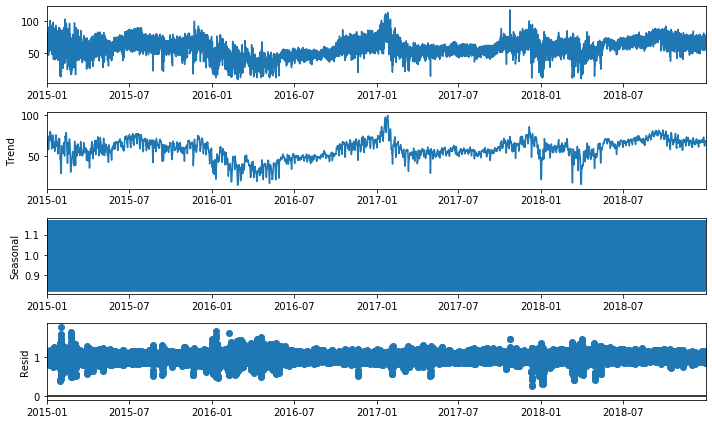

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_energy_new, model='multiplicative')
result.plot()
plt.show()

Now we are going to create an ARIMA model and will train it with the price of the electricity on the train data. So let us split the data into training and test set and visualize it.

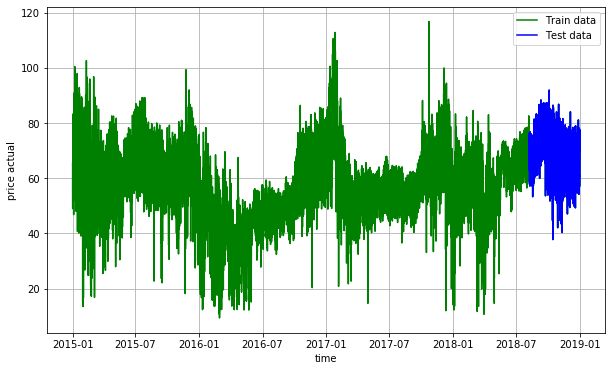

In [78]:
train_data, test_data = df_energy_new[3:int(len(df_energy_new)*0.9)], df_energy_new[int(len(df_energy_new)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('price actual')
plt.plot(df_energy_new, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p → Number of autoregressive terms, refer correlogram

d → Number of nonseasonal differences needed for stationarity, and

q → Number of lagged forecast errors in the prediction equation.

Values of p and q come through ACF and PACF plots. So let us understand both ACF and PACF!

Autocorrelation Function(ACF)
 
Statistical correlation summarizes the strength of the relationship between two variables. Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

Partial Autocorrelation Function(PACF)
 
A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

The autocorrelation for observation and observation at a prior time step is comprised of both the direct correlation and indirect correlations. It is these indirect correlations that the partial autocorrelation function seeks to remove.
Run auto_arima to get the best value of p, d, q

In [80]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=8, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=346048.521, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=304098.039, Time=1.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=164466.182, Time=2.56 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=163058.092, Time=1.39 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=159426.423, Time=11.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.90 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=159164.340, Time=12.98 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=159067.814, Time=14.17 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=1.12 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=159062.464, Time=19.09 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=1.31 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=1

In [83]:
model = ARIMA(train_data, order=(7, 0, 1))
fitted = model.fit(disp=0)
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:           price actual   No. Observations:                31554
Model:                     ARMA(7, 1)   Log Likelihood              -79557.966
Method:                       css-mle   S.D. of innovations              3.011
Date:                Tue, 25 May 2021   AIC                         159135.933
Time:                        00:47:52   BIC                         159219.527
Sample:                    01-01-2015   HQIC                        159162.691
                         - 08-07-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 56.5420      0.678     83.353      0.000      55.212      57.872
ar.L1.price actual     1.9590      0.021     92.997      0.000       1.918       2.000
ar.L2.price actual  

Making forecast with test data

In [86]:
# Forecast
fc, se, conf = fitted.forecast(3507, alpha=0.05)  # 95% confidence

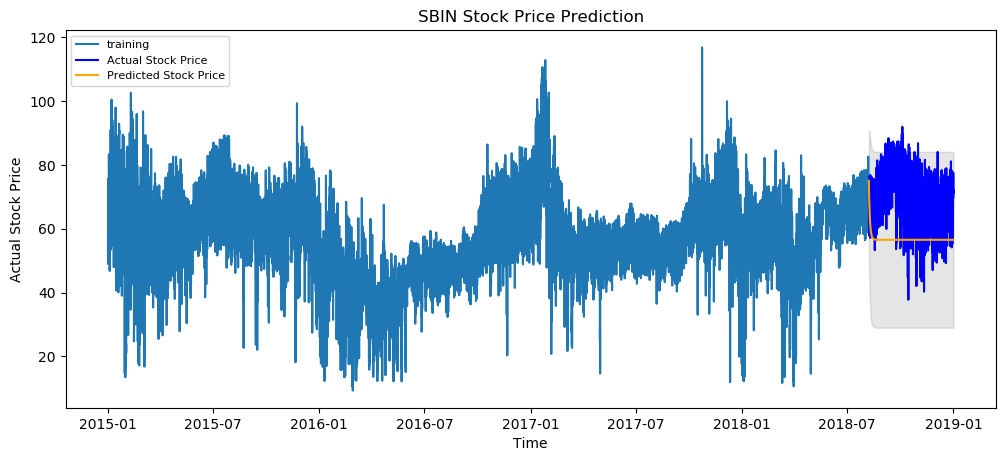

In [87]:
#fc_series = pd.Series(fc, index=test_data.index)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Electricity Price')
plt.plot(fc_series, color = 'orange',label='Predicted Electricity Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Electricity Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Electricity Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Taking log to reduce the trend to make series stationary

If series is not stationary then we need to eliminate the trend and seasonality from the series.

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


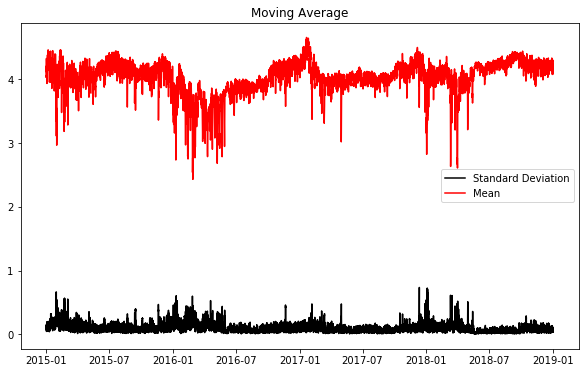

In [88]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_energy_new['price actual'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

In [89]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)


Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

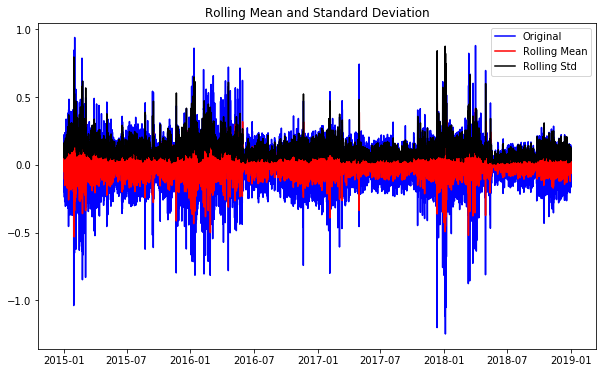

Results of dickey fuller test


KeyError: 'price actual'

In [90]:
test_stationarity(df_log_moving_avg_diff)

rom the above graph, we observed that the data attained stationarity.

One of the modules is completed as we came to a conclusion. We need to check the weighted average, to understand the trend of the data in time series. Take the previous log data and to perform the following operation.


In [91]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period. In other words, the formula gives recent prices more weight than past prices.

Previously we subtracted df_log with moving average, now take the same df_log and subtract with weighted_average and perform the Dickey-Fuller test (ADFT) once again.

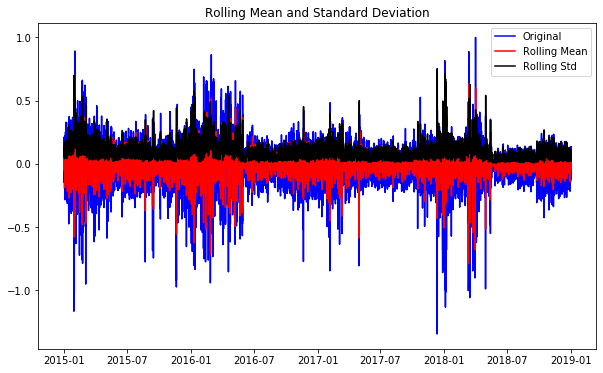

Results of dickey fuller test


KeyError: 'price actual'

In [92]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

From the above graph, we observed that the data attained stationarity. We also see that the test statistics and critical value is relatively equal.

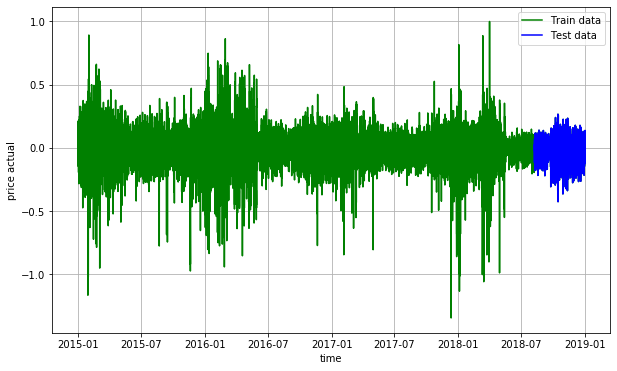

In [93]:
train_data_2, test_data_2 = logScale_weightedMean[3:int(len(logScale_weightedMean)*0.9)], logScale_weightedMean[int(len(logScale_weightedMean)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('price actual')
plt.plot(logScale_weightedMean, 'green', label='Train data')
plt.plot(test_data_2, 'blue', label='Test data')
plt.legend()

In [94]:
model_autoARIMA = auto_arima(train_data_2, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=8, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-24808.660, Time=1.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-78421.418, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-56739.428, Time=1.67 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-90109.764, Time=0.82 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-90500.332, Time=1.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-90512.049, Time=1.28 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-90591.256, Time=1.96 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=-90763.172, Time=2.41 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=-90985.565, Time=2.26 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=-91153.430, Time=2.72 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=-91159.562, Time=27.54 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=-91094.552, Time=25.40 sec
 ARIMA(8,0,2)(0,0,0)[0]             : AIC=-91112.503, Time=29.55 sec
 ARIMA(7,0,2)(0,0,0)[0]             : AIC=-91003.318, Time=26.26 sec
 

Create model with best parameter obtained

In [96]:
model_2 = ARIMA(train_data_2, order=(8, 0, 1))
fitted_2 = model_2.fit(disp=0)
print(fitted_2.summary())

                              ARMA Model Results                              
Dep. Variable:           price actual   No. Observations:                31554
Model:                     ARMA(8, 1)   Log Likelihood               45590.624
Method:                       css-mle   S.D. of innovations              0.057
Date:                Tue, 25 May 2021   AIC                         -91159.249
Time:                        01:10:03   BIC                         -91067.295
Sample:                    01-01-2015   HQIC                        -91129.815
                         - 08-07-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9.131e-05      0.003      0.035      0.972      -0.005       0.005
ar.L1.price actual     1.4745      0.042     35.274      0.000       1.393       1.556
ar.L2.price actual  

In [97]:
# Forecast
fc_2, se_2, conf_2 = fitted_2.forecast(3507, alpha=0.05)  # 95% confidence

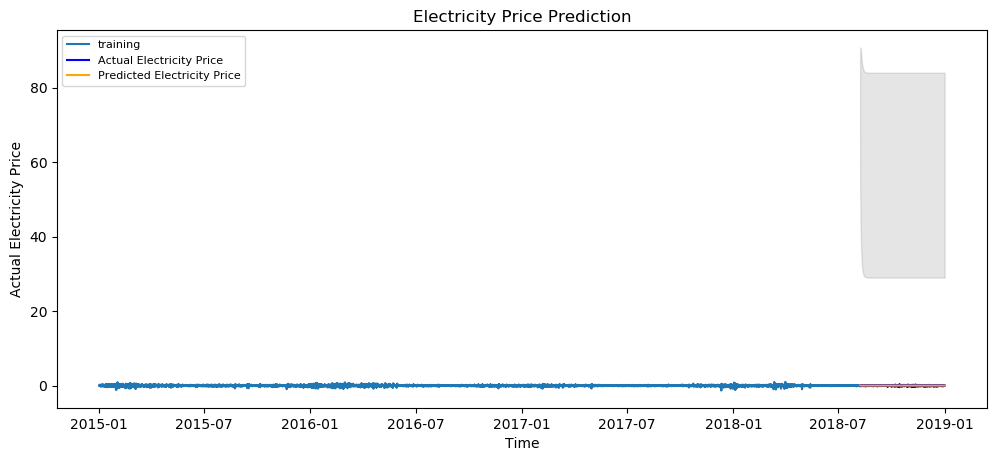

In [98]:
#fc_series = pd.Series(fc, index=test_data.index)
fc_series_2 = pd.Series(fc_2, index=test_data_2.index)
lower_series_2 = pd.Series(conf[:, 0], index=test_data_2.index)
upper_series_2 = pd.Series(conf[:, 1], index=test_data_2.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data_2, label='training')
plt.plot(test_data_2, color = 'blue', label='Actual Electricity Price')
plt.plot(fc_series_2, color = 'orange',label='Predicted Electricity Price')
plt.fill_between(lower_series_2.index, lower_series_2, upper_series_2, 
                 color='k', alpha=.10)
plt.title('Electricity Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Electricity Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Removing seasonality as well

There can be cases when there is a high seasonality in the data.

In those cases, just removing the trend will not help much. We need to also take care of the seasonality in the series. One such method for this task is differencing.

Differencing is a method of transforming a time series dataset.

It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

Differencing is performed by subtracting the previous observation from the current observation.
Perform the Dickey-Fuller test (ADFT) once again.

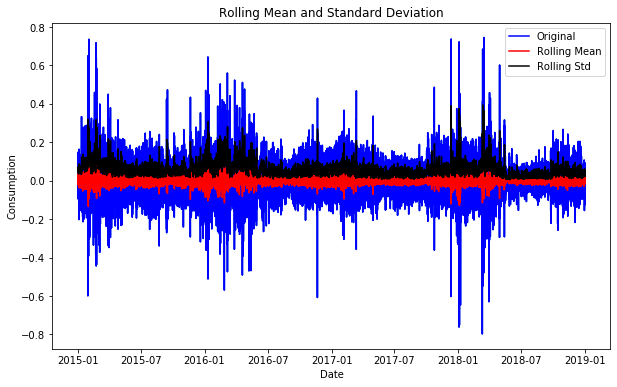

Results of dickey fuller test


KeyError: 'price actual'

In [100]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)


The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model. Finally, perform the Dickey-Fuller test (ADFT) once again.



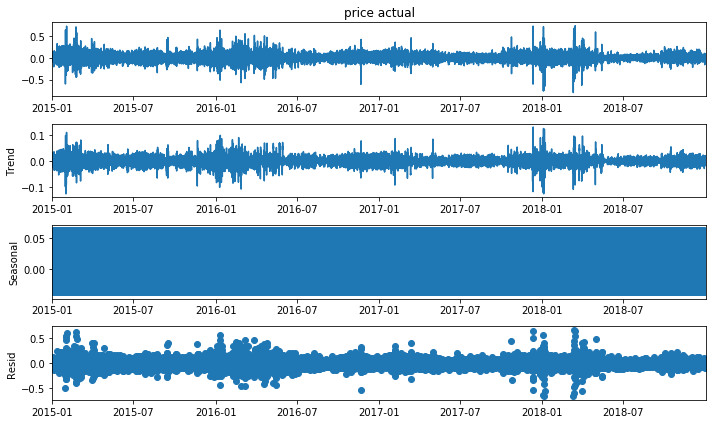

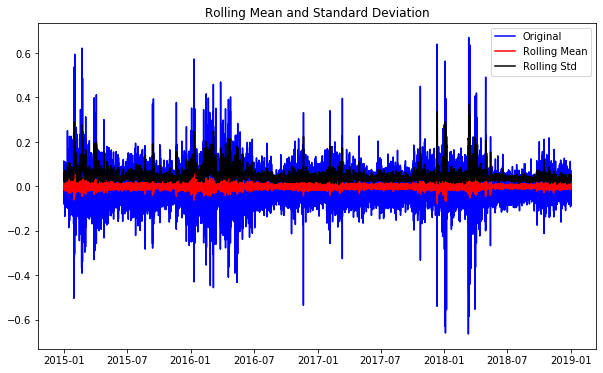

Results of dickey fuller test


KeyError: 'price actual'

In [104]:
result = seasonal_decompose(df_log_diff, model='additive', freq = 12)
result.plot()
plt.show()
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity(residual)




After the decomposition, if we look at the residual then we have clearly a flat line for both mean and standard deviation. We have got our stationary series and now we can move to find the best parameters for our model.

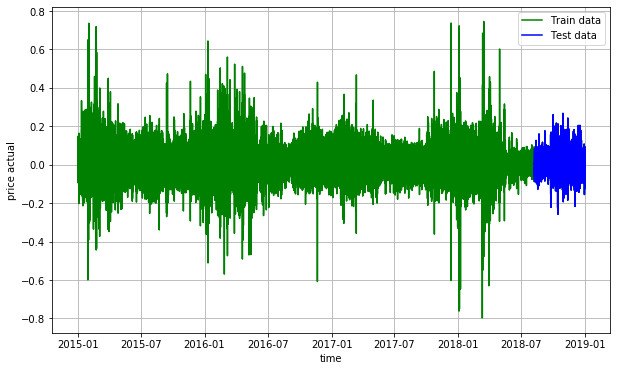

In [106]:
train_data_3, test_data_3 = df_log_diff[3:int(len(df_log_diff)*0.9)], df_log_diff[int(len(df_log_diff)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('time')
plt.ylabel('price actual')
plt.plot(df_log_diff, 'green', label='Train data')
plt.plot(test_data_3, 'blue', label='Test data')
plt.legend()

In [107]:
model_autoARIMA = auto_arima(train_data_3, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=9, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-74501.349, Time=0.94 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-83118.735, Time=0.75 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-81637.941, Time=2.39 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-83186.435, Time=0.83 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-83748.866, Time=1.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-84763.393, Time=1.29 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-85702.857, Time=1.57 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=-86483.684, Time=1.90 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=-86994.122, Time=2.29 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=-87137.654, Time=2.66 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=-87150.599, Time=4.20 sec
 ARIMA(9,0,1)(0,0,0)[0]             : AIC=-87160.002, Time=20.64 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=-87141.029, Time=22.74 sec
 ARIMA(9,0,2)(0,0,0)[0]             : AIC=-87368.188, Time=37.38 sec
 A


OR use below code plots,to get the value of p, d, q

In order to find the p and q values from the above graphs, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graphs the p and q values are merely close to 3 where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.

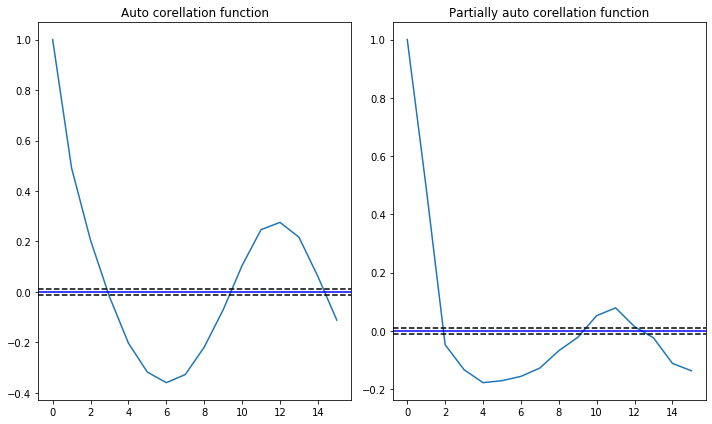

In [112]:

acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

In [111]:
from statsmodels.tsa.stattools import acf,pacf

In [113]:
model_3 = ARIMA(train_data_3, order=(9, 0, 3))
fitted_3 = model_3.fit(disp=0)
print(fitted_3.summary())

                              ARMA Model Results                              
Dep. Variable:           price actual   No. Observations:                31553
Model:                     ARMA(9, 3)   Log Likelihood               45272.755
Method:                       css-mle   S.D. of innovations              0.058
Date:                Tue, 25 May 2021   AIC                         -90517.511
Time:                        01:45:31   BIC                         -90400.479
Sample:                    01-01-2015   HQIC                        -90480.050
                         - 08-07-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.142e-06      0.000      0.005      0.996      -0.001       0.001
ar.L1.price actual     1.1231        nan        nan        nan         nan         nan
ar.L2.price actual  

In [114]:
# Forecast
fc_3, se_3, conf_3 = fitted_3.forecast(3507, alpha=0.05)  # 95% confidence

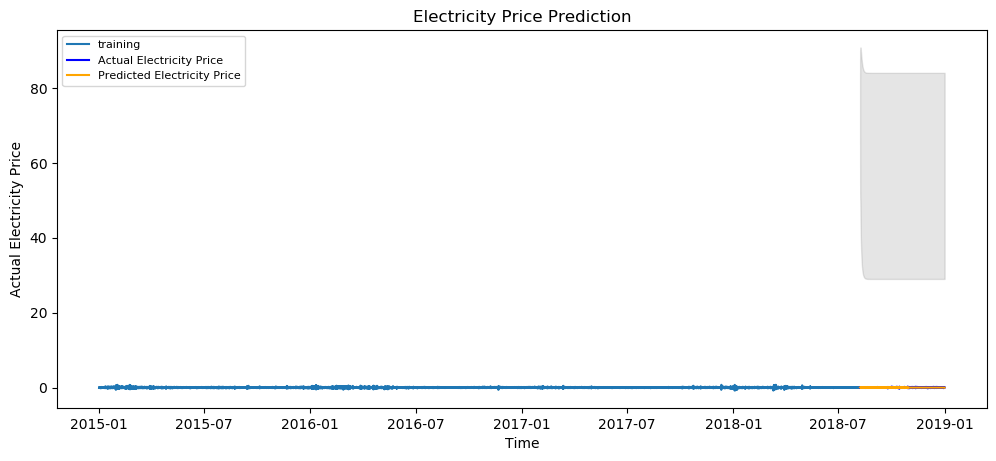

In [115]:
#fc_series = pd.Series(fc, index=test_data.index)
fc_series_3 = pd.Series(fc_3, index=test_data_3.index)
lower_series_3 = pd.Series(conf[:, 0], index=test_data_3.index)
upper_series_3 = pd.Series(conf[:, 1], index=test_data_3.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data_3, label='training')
plt.plot(test_data_3, color = 'blue', label='Actual Electricity Price')
plt.plot(fc_series_3, color = 'orange',label='Predicted Electricity Price')
plt.fill_between(lower_series_3.index, lower_series_3, upper_series_3, 
                 color='k', alpha=.10)
plt.title('Electricity Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Electricity Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

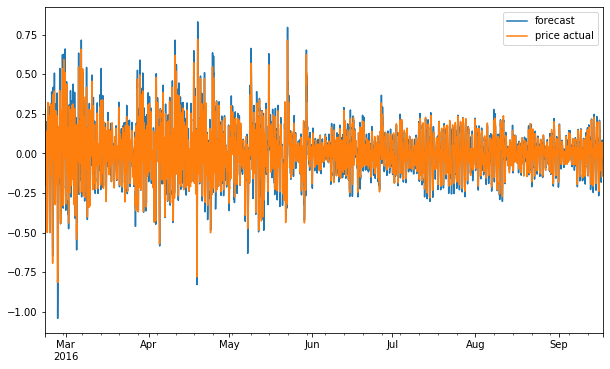

In [119]:
result_AR.plot_predict(10000,15000)


OR use below code plots,to get the value of p, d, q

In order to find the p and q values from the above graphs, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graphs the p and q values are merely close to 3 where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.

In [ ]:

# we use d value here(data_log_shift)
acf = acf(df_log_moving_avg_diff, nlags=15)
pacf= pacf(df_log_moving_avg_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_moving_avg_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_moving_avg_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_moving_avg_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_moving_avg_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

In [86]:

# Forecast
fc, se, conf = fitted.forecast(3507, alpha=0.05)  # 95% confidence

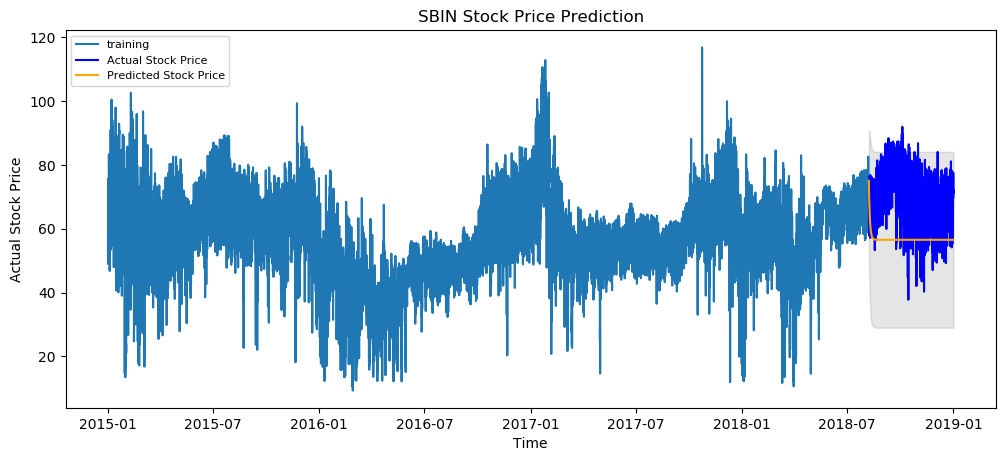

In [87]:
#fc_series = pd.Series(fc, index=test_data.index)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('SBIN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

References

https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather

https://www.analyticsvidhya.com/blog/2020/11/stock-market-price-trend-prediction-using-time-series-forecasting/

https://www.kdnuggets.com/2020/01/predict-electricity-consumption-time-series-analysis.html


> ** Thank you for your time! If you like this notebook, **$\color{magenta}{\text{PLEASE UPVOTE!}}$** Do not hestitate to share your thoughts.